In [77]:
import pandas as pd
from collections import Counter
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model 
from tensorflow.keras.applications import inception_v3, EfficientNetB2, EfficientNetB6
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import optimizers

DATASET_IMAGES = "D:\\food-101\\food-101\\food-101\\images"
DATASET_ROOT = "D:\\food-101\\food-101\\food-101\\meta"
DATASET_LOCATION = os.path.join(DATASET_ROOT, 'train.txt')
DATASET_LOCATION_VALIDATION = os.path.join(DATASET_ROOT, 'test.txt')
DATASET_SIZE = 101
LABELS_FILE = 'classes.txt'

In [16]:
labels = pd.read_csv(os.path.join(DATASET_ROOT, LABELS_FILE), sep='\t')['Classes']
elems = {}
for i in range(len(labels)):
    elems[labels[i]] = i
print(elems)

{'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4, 'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9, 'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14, 'ceviche': 15, 'cheesecake': 16, 'cheese_plate': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19, 'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24, 'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29, 'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34, 'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39, 'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43, 'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48, 'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 5

In [96]:
import cv2, os

class DataGenerator(tf.keras.utils.Sequence):
    
    def __init__(self, db_dir, batch_size, input_shape, num_classes, 
                 shuffle=True, labels_dir=LABELS_FILE, sep='\t', image_dir=DATASET_ROOT):
        # TODO your initialization
        # you might want to store the parameters into class variables
        self.root = db_dir
        self.image_dir = image_dir
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.sep = sep
        # load the data from the root directory
        self.data, self.labels = self.get_data(db_dir)
        self.db_dir = db_dir
        self.names = self.get_labels(DATASET_ROOT, labels_dir)
        self.indices = np.arange(len(self.data))
        self.on_epoch_end()

    def get_labels(self, root_dir, file):
        fi = os.path.join(root_dir, file)
        rez = {}
        with open(fi, 'r') as f:
            f.readline()
            for line in f.readlines():
                line = line.strip()
                el = line.split(self.sep)
                rez[el[0]] = " ".join(el[1:])
        return rez

    def get_data(self, root_dir):
        """"
        Loads the paths to the images and their corresponding labels from the database directory
        """
        # TODO your code here
        x = []
        y = []
        with open(root_dir, 'r') as file:
            for el in file.readlines():
                el = el.strip()
                paths = el.split("/")
                name = paths[1] + ".jpg"
                x.append(os.path.join(self.image_dir, paths[0], name))
                y.append(elems[paths[0]])
        self.data = np.array(x)
        self.labels = self.to_categorical(np.array(y), num_classes=self.num_classes)
        return self.data, self.labels

    def to_categorical(self, arr, num_classes):
        rez = np.zeros((len(arr), num_classes), dtype=np.float)
        for index in range(len(arr)):
            rez[index, arr[index]] = 1
        return rez

    def __len__(self):
        """
        Returns the number of batches per epoch: the total size of the dataset divided by the batch size
        """
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        """"
        Generates a batch of data
        """
        batch_indices = self.indices[index*self.batch_size : (index+1)*self.batch_size]
        x = []
        for ind in batch_indices:
            try:
                im = cv2.imread(self.data[ind])
                im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                if im_rgb.shape != (224,224,3):
                    im_rgb = cv2.resize(im_rgb, (224,224))
                x.append(im_rgb)
            except Exception as e:
                raise e
        batch_x = np.array(x).astype(np.float) # TODO load the image from batch_indices
        batch_y = np.array([self.labels[el] for el in batch_indices]) # TODO load the corresponding labels of the images you loaded
        # optionally you can use: batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.num_classes)
        return batch_x, batch_y

    def on_epoch_end(self):
        """"
        Called at the end of each epoch
        """
        # if required, shuffle your data after each epoch
        self.indices = np.arange(len(self.data))
        if self.shuffle:
            # TODO shuffle data
            # you might find np.random.shuffle useful here
            np.random.shuffle(self.indices)


In [97]:
gen = DataGenerator(DATASET_LOCATION, 32, (224, 224, 3), DATASET_SIZE, image_dir=DATASET_IMAGES)
val_gen = DataGenerator(DATASET_LOCATION_VALIDATION, 32, (224, 224, 3), DATASET_SIZE, image_dir=DATASET_IMAGES)

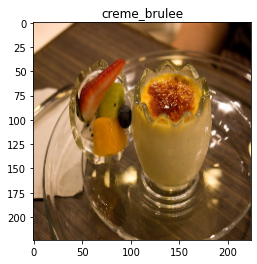

In [98]:
ims, lbls = gen[0]
imgplot = plt.imshow(ims[0].astype('uint8'), vmin=0, vmax=255)
plt.title(labels[np.argmax(lbls[0] == 1)])
plt.show()

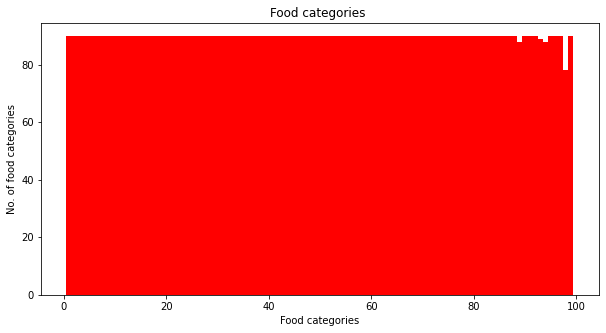

In [8]:
from collections import Counter
vals = Counter(categs)

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(vals.keys(), vals.values(), color ='red',
        width = 1)
 
plt.xlabel("Food categories")
plt.ylabel("No. of food categories")
plt.title("Food categories ")
plt.show()

In [85]:
base_model = inception_v3.InceptionV3(weights='imagenet', include_top=False)
base_model = EfficientNetB2(include_top = False, weights='imagenet')

# add a global spatial average pooling layer
x = base_model.output
base_model.trainable = False
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# and a logistic layer
predictions = Dense(DATASET_SIZE, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, None, None, 3 0           input_11[0][0]                   
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, None, None, 3 7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_4[0][0]            
____________________________________________________________________________________________

In [102]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(patience=3)

checkpointer = ModelCheckpoint(os.path.join('models', 'efficientnetb2_' + 'single-label' + '_best.h5'), verbose=1, save_best_only=True)

In [103]:
history = model.fit(gen, epochs=8, callbacks=[early_stopping, checkpointer, lrScheduler], validation_data=val_gen)

Epoch 1/8
2367/2367 [==============================] - 5825s 2s/step - loss: 2.4131 - accuracy: 0.5980 - val_loss: 1.6017 - val_accuracy: 0.6814

Epoch 00001: val_loss improved from inf to 1.60174, saving model to models\efficientnetb2_single-label_best.h5
Epoch 2/8
2367/2367 [==============================] - 5593s 2s/step - loss: 2.1617 - accuracy: 0.6110 - val_loss: 1.5047 - val_accuracy: 0.6877

Epoch 00002: val_loss improved from 1.60174 to 1.50473, saving model to models\efficientnetb2_single-label_best.h5
Epoch 3/8
2367/2367 [==============================] - 5517s 2s/step - loss: 2.0133 - accuracy: 0.6196 - val_loss: 1.4392 - val_accuracy: 0.6915

Epoch 00003: val_loss improved from 1.50473 to 1.43922, saving model to models\efficientnetb2_single-label_best.h5
Epoch 4/8
2367/2367 [==============================] - 5644s 2s/step - loss: 1.9050 - accuracy: 0.6217 - val_loss: 1.3906 - val_accuracy: 0.6936

Epoch 00004: val_loss improved from 1.43922 to 1.39058, saving model to mod

In [105]:
print(history.history)

{'loss': [2.413149118423462, 2.161680221557617, 2.0133297443389893, 1.9050240516662598, 1.823580265045166, 1.725051760673523, 1.6638147830963135, 1.6244709491729736], 'accuracy': [0.597987949848175, 0.6109526753425598, 0.6196134090423584, 0.6216729879379272, 0.6273632049560547, 0.6347829699516296, 0.6358655691146851, 0.6413445472717285], 'val_loss': [1.601742148399353, 1.5047328472137451, 1.4392204284667969, 1.390577793121338, 1.3467731475830078, 1.3158609867095947, 1.2891408205032349, 1.2646472454071045], 'val_accuracy': [0.6814401149749756, 0.687658429145813, 0.6915399432182312, 0.6935995221138, 0.6978374719619751, 0.698471188545227, 0.6996594071388245, 0.7030259966850281], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.00090483745, 0.0008187308, 0.0007408183]}


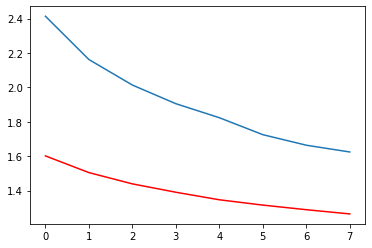

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='red')
plt.show()

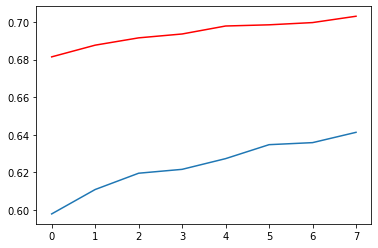

In [109]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'], color='red')
plt.show()